In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore")



Using TensorFlow backend.


loading data for testing

In [0]:
# x_tr=pd.read_csv("/content/drive/My Drive/dataset/iit delhi/x_train.csv")
# x_val=pd.read_csv("/content/drive/My Drive/dataset/iit delhi/x_val.csv")
# y_tr=pd.read_csv("/content/drive/My Drive/dataset/iit delhi/y_train.csv")
# y_val=pd.read_csv("/content/drive/My Drive/dataset/iit delhi/y_val.csv")

# x_tr=x_tr['comment']
# x_val=x_val['comment']
# y_tr=y_tr['summary']
# y_val=y_val['summary']

# print(len(x_tr))
# print(len(y_tr))
# print(len(x_val))
# print(len(y_val))


loading tokenizer

In [0]:
x_tokenizer = Tokenizer()
y_tokenizer = Tokenizer()

In [0]:
import pickle
with open('/content/drive/My Drive/dataset/iit delhi/x_tokenizer.pickle', 'rb') as handle:
    x_tokenizer = pickle.load(handle)

with open('/content/drive/My Drive/dataset/iit delhi/y_tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)

In [0]:
y_voc_size  =   len(y_tokenizer.word_index) +1
x_voc_size  =   len(x_tokenizer.word_index) +1

In [0]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(list(x_tr)) 
x_val   =   x_tokenizer.texts_to_sequences(list(x_val))

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

In [0]:

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

In [19]:
print(len(x_tr))
print(len(y_tr))
print(len(x_val))
print(len(y_val))

70467
70467
7830
7830


In [0]:
from tensorflow.keras import backend as K
K.clear_session()

max_lent_text and dimension must be same as in model

In [21]:
max_len_text=100
max_len_summary=35
latent_dim=500

#first we will define all the layers of the model than add them 

######encoder
encoder_inputs=Input(shape=(max_len_text,))

#embedding
enc_emb=Embedding(x_voc_size,latent_dim,trainable=True)(encoder_inputs)

#lstm 1
encoder_lstm1=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1,state_h1,state_c1=encoder_lstm1(enc_emb)

#lstm2
encoder_lstm2=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h,state_c=encoder_lstm2(encoder_output1)

#####decoder
decoder_inputs=Input(shape=(None,))

#embedding
dec_emb_layer=Embedding(y_voc_size,latent_dim,trainable=True)
dec_emb=dec_emb_layer(decoder_inputs)

#lstm1
decoder_lstm=LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,decoder_fwd_state,decoder_back_state=decoder_lstm(dec_emb,initial_state=[state_h,state_c])

#Attention layer
attn_layer=AttentionLayer(name='attention_layer')
attn_out,attn_state=attn_layer([encoder_outputs,decoder_outputs])

#concatenate attention output with decoder output
decoder_concat_input=Concatenate(axis=-1,name='concat_layer')([decoder_outputs,attn_out])

#dense layer
#importnat to study timedistributed layer and its feature

decoder_dense=TimeDistributed(Dense(y_voc_size,activation='softmax'))
decoder_outputs=decoder_dense(decoder_concat_input)

#now summing up the model
model=Model([encoder_inputs,decoder_inputs],decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     140590500   input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 500), ( 2002000     embedding[0][0]                  
______________________________________________________________________________________________

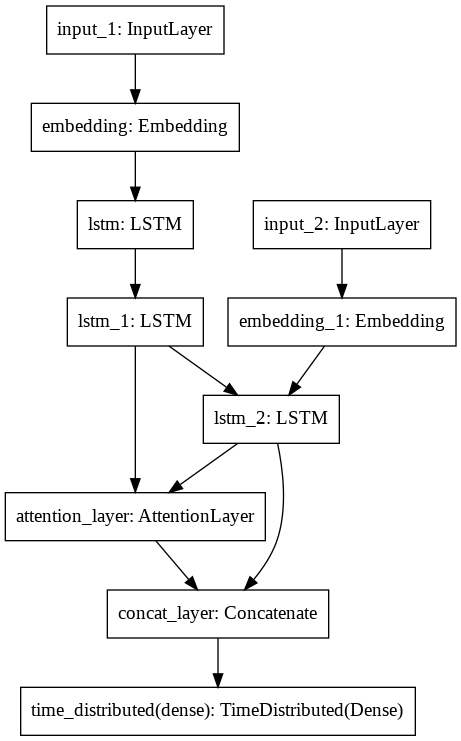

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/dataset/iit delhi/model1.png')

In [0]:
model.load_weights("/content/drive/My Drive/dataset/iit delhi/touristsumm1.h5")

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
#inference main part of language modelling

#encoder
encoder_model=Model(inputs=encoder_inputs,outputs=[encoder_outputs,state_h,state_c])

#decoder
decoder_state_input_h=Input(shape=(latent_dim,))
decoder_state_input_c=Input(shape=(latent_dim,))
decoder_hidden_state_input=Input(shape=(max_len_text,latent_dim))#this is the ouptut of encoder for each text

#get the embedding of decoder

dec_emb2=dec_emb_layer(decoder_inputs)

#to predict the next word 
decoder_outputs2,state_h2,state_c2=decoder_lstm(dec_emb2,initial_state=[decoder_state_input_h,decoder_state_input_c])

#attention layer inference
attn_out_inf,attn_states_inf=attn_layer([decoder_hidden_state_input,decoder_outputs2])
decoder_inf_concat=Concatenate(axis=-1,name='concat')([decoder_outputs2,attn_out_inf])

#dense softmax layer to generate prob distri.
decoder_outputs2=decoder_dense(decoder_inf_concat)

#final decoder model
decoder_model=Model([decoder_inputs]+[decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c],[decoder_outputs2]+[state_h2,state_c2])


In [0]:
#defing function for inference
# updating the  input of decoder and h and c 

def decode_sequence(input_seq):
    #encode the input as state vector
    e_out,e_h,e_c=encoder_model.predict(input_seq)
    target_seq=np.zeros((1,1))
    target_seq[0,0]=target_word_index['start']
    
    stop_condition=False
    decoded_sentence=''
    
    while not stop_condition:
        output_tokens,h,c=decoder_model.predict([target_seq]+[e_out,e_h,e_c])
        
        #sample a token
        sampled_token_index=np.argmax(output_tokens[0,-1,:])
        sampled_token=reverse_target_word_index[sampled_token_index]
#         print(sampled_token_index)
        if (sampled_token!='end'):
            decoded_sentence+=' '+sampled_token
            
            #checking exit condition
        if(sampled_token=='end' or len(decoded_sentence.split())>=(max_len_summary-1) ):
            stop_condition=True
            
        #update input word of decoder to previous predict word    
        target_seq=np.zeros((1,1))
        target_seq[0,0]=sampled_token_index
        #update h and c
        e_h,e_c=h,c
    return decoded_sentence

In [0]:
#now lets make a function to convert all the input text ,summary from int to text

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if (i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


for testing available data

In [0]:

# for i in range(10):
#   print(i)
#   print("Review:",seq2text(x_val[i]))
#   print("Original summary:",seq2summary(y_val[i]))
#   print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
#   print("\n")

To test a customise data

In [0]:
ck=["The Taj Mahal (/ˌtɑːdʒ məˈhɑːl, ˌtɑːʒ-/;[4] lit. 'Crown of the Palace', [taːdʒ ˈmɛːɦ(ə)l])[5] is an ivory-white marble mausoleum on the southern bank of the river Yamuna in the Indian city of Agra. It was commissioned in 1632 by the Mughal emperor Shah Jahan (reigned from 1628 to 1658) to house the tomb of his favourite wife, Mumtaz Mahal; it also houses the tomb of Shah Jahan himself. The tomb is the centrepiece of a 17-hectare (42-acre) complex, which includes a mosque and a guest house, and is set in formal gardens bounded on three sides by a crenellated wall."]

In [0]:
ck.append("The Red Fort is a historic fort in the city of Delhi in India that served as the main residence of the Mughal Emperors. Emperor Shah Jahan commissioned construction of the Red Fort on 12 May 1638, when he decided to shift his capital from Agra to Delhi. Originally red and white, Shah Jahan's favourite colours, its design is credited to architect Ustad Ahmad Lahori, who also constructed the Taj Mahal. It was constructed between May 1639 and April 1648.")

In [0]:
ck.append("The India Gate was part of the work of the Imperial War Graves Commission (I.W.G.C), which came into existence in December 1917 for building war graves and memorials to soldiers who were killed in the First World War[3] The foundation stone of the gate, then called the All India War Memorial, was laid on 10 February 1921, at 16:30, by the visiting Duke of Connaught in a ceremony attended by Officers and Men of the British Indian Army, Imperial Service Troops, the Commander in Chief, and Chelmsford, the viceroy.[4] On the occasion, the viceroy is reportedly to have said, The stirring tales of individual heroism, will live for ever in the annals of this country, and that the memorial which was a tribute to the memory of heroes, known and unknown, would inspire future generations to endure hardships with similar fortitude and no less valour ")

In [0]:
import numpy as np

ck2=np.array(ck)

In [75]:
print(type(x_tr))
print(type(ck2))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
#convert text sequences into integer sequences
ck2   =   x_tokenizer.texts_to_sequences(list(ck2))

#padding zero upto maximum length
ck2    =   pad_sequences(ck2,  maxlen=max_len_text, padding='post')

In [77]:
for i in range(len(ck)):
  print(i)
  print("Predicted summary:",decode_sequence(ck2[i].reshape(1,max_len_text)))
  print("\n")


0
Predicted summary:  taj mahal lit bearing white marble mausoleum southern bank river yamuna indian city agra commissioned mughal emperor shah jahan one taj mahal going fort prime jahan rajasthan started set formal gardens alok


1
Predicted summary:  red fort historic fort city delhi india delhi originally red white shah favourite colours design credited architect ysjagan


2
Predicted summary:  india gate part work imperial war graves held nation killed first world war foundation stone gate called india war memorial laid february visiting capture iconic religious india war memorial laid february visiting capture initiative


